In [188]:
# Import libraries and functions
import random
import itertools
import math
import torch
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# General Setup
torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [189]:
# load and modify the data
pokemon = pd.read_csv('C:\\Users\\Kkda\\Desktop\\Stat 441 Final Project\\scrape_from_scratch.csv')
# Store the labels for  later use
type_1_label = pokemon['type_1'].tolist()
type_2_label = pokemon['type_2'].tolist()

# Define columns
to_drop = ["type_2"]

categorical = ['status']

weakness = ['damage_from_normal', 'damage_from_fire', 'damage_from_water', 'damage_from_electric',
            'damage_from_grass', 'damage_from_ice', 'damage_from_fighting', 'damage_from_poison',
            'damage_from_ground', 'damage_from_flying', 'damage_from_psychic', 'damage_from_bug','damage_from_rock',
            'damage_from_ghost', 'damage_from_dragon', 'damage_from_dark','damage_from_steel', 'damage_from_fairy']

# Drop unwanted variables
pokemon = pokemon.drop(columns=to_drop+weakness)

# Define class and features
y = pokemon['type_1']; # Class
X = pokemon.drop(['type_1'],axis=1) # Feature

# Store the label names
y_label = pokemon['type_1']

# Encode categorical variables
y = pd.get_dummies(y);
X = pd.get_dummies(X,columns=categorical)

# Scale numerical variables
scaler = MinMaxScaler()

ending = sum(X.dtypes == ["float64"]*X.shape[1])
X.iloc[:,:ending] = scaler.fit_transform(X.iloc[:,:ending])

# Convert training and testing data into PyTorch tensor
y = torch.tensor(y.values).float();
X = torch.tensor(X.values).float()

# Set up number classes and features
n_class = 18
n_feature = X.shape[1]


In [3]:
# Define model
class NN(nn.Module):
    
    def __init__(self, node_list,drop):
        super(NN, self).__init__()
        
        self.layers = nn.ModuleList()
        for i in range(1, len(node_list)):
            self.layers.append(nn.Linear(node_list[i-1], node_list[i]))
        
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(p=drop)
        
    def forward(self, x):
        out = x
        for i in range(len(self.layers)-1):
            out = self.layers[i](out)
            out = self.activation(out)
        out = self.layers[len(self.layers)-1](out)
        return out

In [4]:
# Prediction function
def predict(model, X, y):
    
    # Set up loader
    test_dataset = TensorDataset(X,y)
    loader = DataLoader(test_dataset, batch_size = 9999, shuffle = False)
    
    # Set model to evaluation
    model.eval()
    
    # Evaluate model
    num_correct = 0
    num_samples = 0
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)
            x = x.reshape(x.shape[0], -1)
            model_result = model(x)
            _, prediction = model_result.max(1)
            _, actual = y.max(1)
            num_correct += (prediction == actual).sum()
            num_samples += prediction.size(0)
    
    # Set model to training
    model.train()
    accuracy = num_correct/num_samples
    
    return prediction.cpu().numpy(), actual.cpu().numpy(), accuracy.cpu().item()

In [5]:
# Training function
# Input: Model hyper parameters, training and testing data
# Output: Model, Loss
def train_model(num_epochs, batch_size, node_list, drop, X, y):

    # Create the model
    model = NN([n_feature]+node_list+[n_class], drop).to(device)

    # Set up loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())
    
    # Set up data loader
    train_dataset = TensorDataset(X,y)
    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
    
    # Initialize loss
    loss = []
    
    # Train model
    for epoch in range(num_epochs):
        for batch_idx, (data, targets) in enumerate(train_loader):
            # Get data to cuda if possible
            data = data.to(device = device)
            targets = targets.to(device = device)

            # Reshape data
            data = data.reshape(data.shape[0], -1)
            
            # Forward propagation
            model_result = model(data)
            current_loss = criterion(model_result, targets)
            
            # Zero previous gradients
            optimizer.zero_grad()
            
            # back-propagation
            current_loss.backward()
            
            # optimize
            optimizer.step()
        
        # Record loss of the current epoch
        loss.append(float(current_loss.item()))
            
    return model, loss

In [122]:
def model_examination(num_epochs, batch_size, node_list, drop, X_train, y_train, X_test, y_test):
    # Train model
    model, loss = train_model(num_epochs, batch_size, node_list, drop, X_train, y_train)
    # Estimate model accuracy
    pred, actual, accuracy = predict(model, X_test, y_test)
    
    return model, loss, pred, actual, accuracy

In [117]:
def model_examination_repeated_cv(num_epochs, batch_size, node_list, drop, X, y, n_split, repeat, y_label):
    
    # Set up and initialize
    skf = StratifiedKFold(n_splits=n_split,random_state=441, shuffle=True)
    acc = []
    
    # Perform k-fold cv n times, record result for every model trained
    for ii in tqdm(range(repeat),leave=False):
        acc_temp = []
        for idx, (train_index, test_index) in enumerate(skf.split(X,y_label)):
            X_test = X[test_index]
            y_test = y[test_index]
            X_train = X[train_index]
            y_train = y[train_index]
            model, _ = train_model(num_epochs,batch_size,node_list,drop,X_train,y_train)
            _,_, accuracy = predict(model, X_test, y_test)
            accuracy = accuracy
            acc_temp.append(accuracy)
        acc.append(acc_temp)

    return acc

In [118]:
def merge_list(lst):
    lst_final = list(itertools.chain.from_iterable(lst))
    return lst_final

# Check if function works properly

NN(
  (layers): ModuleList(
    (0): Linear(in_features=37, out_features=1300, bias=True)
    (1): Linear(in_features=1300, out_features=1300, bias=True)
    (2): Linear(in_features=1300, out_features=18, bias=True)
  )
  (activation): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
)
0.49763035774230957


  0%|          | 0/5 [00:00<?, ?it/s]

[[0.44549763202667236, 0.4265403151512146, 0.4123222827911377, 0.45497632026672363, 0.4571428894996643], [0.42180097103118896, 0.48341232538223267, 0.43127962946891785, 0.4644550085067749, 0.4761905074119568], [0.4265403151512146, 0.45497632026672363, 0.40758293867111206, 0.5071090459823608, 0.4619047939777374], [0.43127962946891785, 0.4644550085067749, 0.41706162691116333, 0.46919432282447815, 0.46666669845581055], [0.4644550085067749, 0.46919432282447815, 0.4123222827911377, 0.48341232538223267, 0.4476190507411957]]
0.4502956628799438


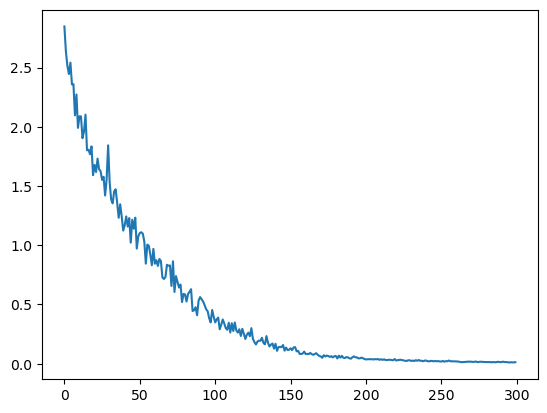

In [106]:
num_epochs,batch_size,drop = 300,250,0.3
node_list = [1300,1300]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=random.seed(time.time()))
model, loss, pred, actual, accuracy = model_examination(num_epochs, batch_size, node_list, drop,
                                                        X_train, y_train, X_test, y_test)
print(model)
print(accuracy)
plt.plot(loss)

acc_test = model_examination_repeated_cv(num_epochs,batch_size,node_list,drop,X,y,5,5,y_label)
print(acc_test)
acc_test_merged = merge_list(acc_test)
print(sum(acc_test_merged)/len(acc_test_merged))

# Examine how number of layers and nodes affect the performance

In [34]:
max_hidden_layer = 4
node_max_multiplier = 11
num_epochs,batch_size,drop = 600,200,0.2

acc_1 = []

# Fix number of hidden layer
for i in tqdm(range(max_hidden_layer)):
    # Number of nodes per layer
    for j in tqdm(range(node_max_multiplier),leave=False):
        node_list = [1000+100*j]*(i+1)
        acc_list =model_examination_repeated_cv(num_epochs,batch_size,node_list,drop,X,y,5,5,y_label)
        # Record result for each set up
        acc_1.append(acc_list)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

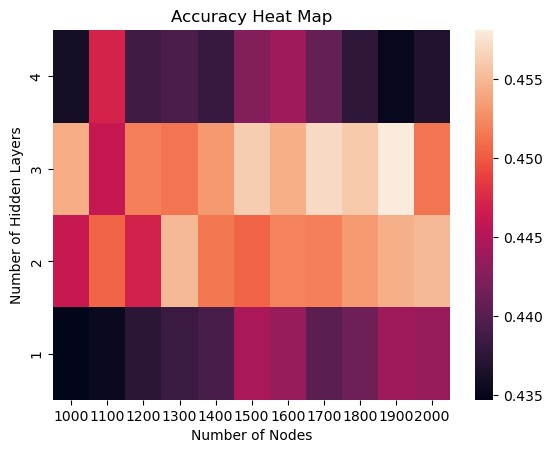

In [49]:
# Create heat map
acc_1_temp = acc_1 # Save the result into a temporary variable that will be modified

# transform acc_1_temp into heat map list
hmlst1 = [[],[],[],[]]
counter = 0
for i in range(max_hidden_layer):
    for j in range(node_max_multiplier):
        merged_list = merge_list(acc_1_temp[counter])
        hmlst1[i].append(sum(merged_list)/len(merged_list))
        counter += 1
hmlst1 = hmlst1[::-1]
hm1 = sns.heatmap(hmlst1)
hm1.set_xlabel('Number of Nodes')
hm1.set_ylabel('Number of Hidden Layers')
hm1.set_xticklabels(list(range(1000,2100,100)))
hm1.set_yticklabels(list(range(4,0,-1)))
plt.title('Accuracy Heat Map')
plt.show()

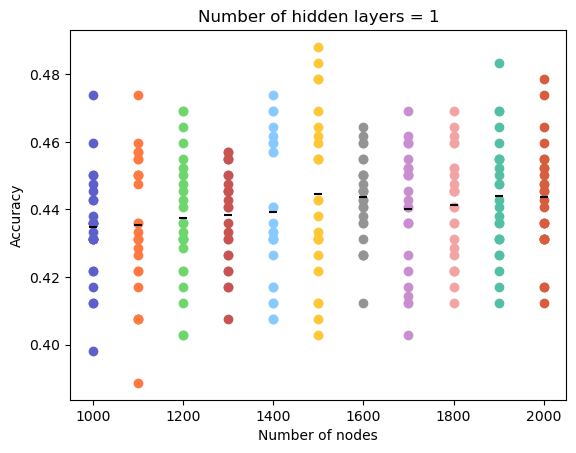

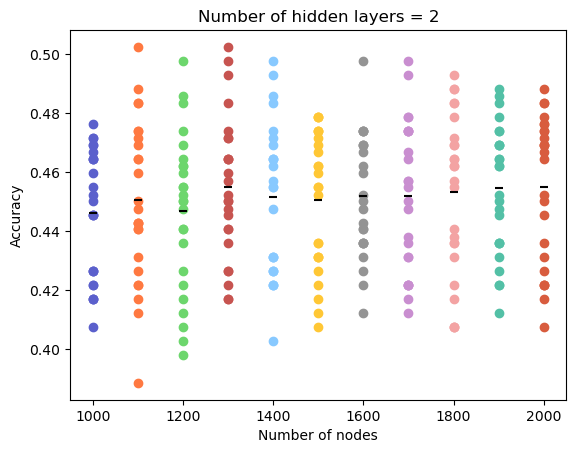

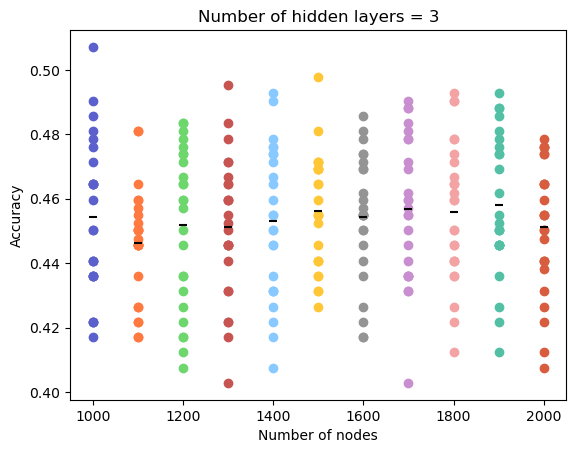

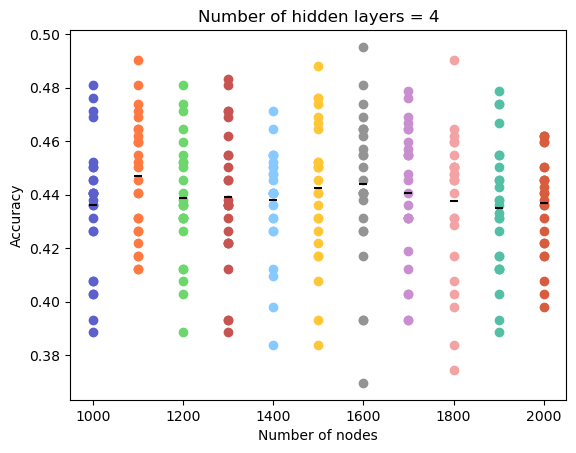

In [84]:
# Create scatterplot for each layer
scatter = [[],[],[],[]]
colors = ['#5b60cc', '#ff7941', '#6dd66d', '#c75450', '#88c9ff', '#ffc735', '#949494', '#c98ed0', '#f3a3a3', '#53c0a6', '#d85c3e']
counter = 0
# Extract the data
for i in range(max_hidden_layer):
    for j in range(node_max_multiplier):
        scatter[i].append(merge_list(acc_1_temp[counter]))
        counter += 1
        
# Plot for different layers
for ii in range(4):
    fig, ax = plt.subplots()
    for i, lst in enumerate(scatter[ii]):
        x = [i*100+1000]*len(lst)
        color_index = i%len(colors)
        ax.scatter(x,lst,color=colors[color_index])
        ax.scatter(i*100+1000,sum(lst)/len(lst),marker="_",color='black')
    ax.set_xlabel('Number of nodes')
    ax.set_ylabel('Accuracy')
    ax.set_title('Number of hidden layers = '+str(ii+1))
    plt.show()

It appeared from the heat map that [1900,1900,1900] performed the best. However, if we examine the data in detail, we realize that [1300,1300] is also performing well. It's average accuracy is considerably high and has a better worst computed prediction accuracy comparing to other models. Also, it is easier to fit a [1300,1300] list. Thus we will optimize further using node list [1300,1300]

In [109]:
# Optimize drop rate, batch size and learning rate using 2 layers with 250 nodes per layer
epoch_lst = [100,150,200,250,300]
batch_lst = [100,125,150,175,200,225,250]
drop_lst = [0.2,0.225,0.25,0.275,0.3]

# Optimal node_list
node_list = [1300,1300]

acc_2 = []
for i in tqdm(range(len(epoch_lst))):
    acc_batch = []
    for j in tqdm(range(len(batch_lst)),leave=False):
        acc_drop = []
        for k in tqdm(range(len(drop_lst)),leave=False):
            drop = drop_lst[k]/100;
            batch_size = batch_lst[j]
            num_epochs = epoch_lst[i]
            acc_list = merge_list(model_examination_repeated_cv(num_epochs,batch_size,node_list,drop,X,y,5,5,y_label))
            acc_drop.append(sum(acc_list)/len(acc_list))
        acc_batch.append(acc_drop)
    acc_2.append(acc_batch)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [112]:
acc_2_temp = acc_2
print(acc_2_temp)

[[[0.4497188127040863, 0.4520009207725525, 0.4459273457527161, 0.445552716255188, 0.4493468904495239], [0.44593276619911193, 0.44308464765548705, 0.4402365326881409, 0.44441075921058654, 0.44877094984054566], [0.4423245501518249, 0.44384294033050536, 0.4449803829193115, 0.44669196248054505, 0.44593457102775574], [0.43928956508636474, 0.44136945724487303, 0.4434674084186554, 0.4402356290817261, 0.4398564803600311], [0.4442139625549316, 0.4379490077495575, 0.4349230587482452, 0.4387190389633179, 0.43948004364967347], [0.4402365303039551, 0.44155993342399597, 0.4345357823371887, 0.43909909009933473, 0.4373857069015503], [0.4390990912914276, 0.44080796003341677, 0.4358600914478302, 0.4394674015045166, 0.4408016395568848]], [[0.4557978105545044, 0.4582622635364533, 0.4519991159439087, 0.45390026807785033, 0.4501006710529327], [0.45010247707366946, 0.44688243746757506, 0.446882438659668, 0.44441707849502565, 0.44953465819358823], [0.44593366980552673, 0.45086889624595644, 0.44782307982444763

In [115]:
# check how epcoh affects the accuracy
epoch_result = []
for i in range(len(epoch_lst)):
    lst_temp = []
    for j in range(len(batch_lst)):
        for k in range(len(drop_lst)):
            lst_temp.append(acc_2_temp[i][j][k])
    epoch_result.append(sum(lst_temp)/len(lst_temp))

batch_result = []
for j in range(len(batch_lst)):
    lst_temp = []
    for i in range(len(epoch_lst)):
        for k in range(len(drop_lst)):
            lst_temp.append(acc_2_temp[i][j][k])
    batch_result.append(sum(lst_temp)/len(lst_temp))

drop_result = []
for k in range(len(drop_lst)):
    lst_temp = []
    for i in range(len(epoch_lst)):
        for j in range(len(batch_lst)):
            lst_temp.append(acc_2_temp[i][j][k])
    drop_result.append(sum(lst_temp)/len(lst_temp))

print(epoch_result)
print(batch_result)
print(drop_result)

max_index = [0,0,0]
current_max = 0
for i in range(len(epoch_lst)):
    for j in range(len(batch_lst)):
        for k in range(len(drop_lst)):
            val_temp = acc_2_temp[i][j][k]
            if val_temp > current_max:
                max_index = [i,j,k]
                current_max = val_temp
print(max_index)
print(acc_2_temp[max_index[0]][max_index[1]][max_index[2]])

min_index = [0,0,0]
current_min = 1
for i in range(len(epoch_lst)):
    for j in range(len(batch_lst)):
        for k in range(len(drop_lst)):
            val_temp = acc_2_temp[i][j][k]
            if val_temp < current_min:
                min_index = [i,j,k]
                current_min = val_temp
print(min_index)
print(acc_2_temp[min_index[0]][min_index[1]][min_index[2]])

[0.44220324649129605, 0.44708524155616763, 0.44911460692541955, 0.4488919418879917, 0.44927985770361767]
[0.4517586279869079, 0.4482457772254943, 0.4479267164707184, 0.4459465211391449, 0.44741836996078477, 0.44424563164711, 0.4456632079601288]
[0.44725340758051196, 0.4472911416121892, 0.44691702427182883, 0.44759507857050207, 0.44751824252946043]
[2, 0, 3]
0.45940150737762453
[0, 5, 2]
0.4345357823371887


Unlike the training with type_2 and damage_from variable in which case we realized optimizing for number of epochs, batch size and drop rate are unnecessary, the training without type_2 and damage_from seem to depend on these hyperparameters. In particular, we noticed that the optimal model is trained with epoch = 200, batch = 100 and drop = 0.275 and has a prediction accuracy 0.459. The worst model is trained with epcoh 100, batch 225, drop rate =  0.25 with prediction accuracy 0.43536. We also noticed that increasing batch size tend to lead to a worse performance. We believe this is because the data is noisy and difficult to generalize. Thus, a smaller batch allows the model to analyze the characteristics of data more frequently and in a detailed way.

In [124]:
# Do a random nested CV to examine the NN performence,
skf = StratifiedKFold(n_splits = 5, random_state = 441, shuffle = True)
acc = []
pred_lst = []
actual_lst = []
for idx, (train_index, test_index) in enumerate(skf.split(X,y_label)):
    print('Split: '+ str(idx+1))
    # Split the data
    X_test = X[test_index]; y_test = y[test_index]; y_label_test = y_label[test_index];
    X_train = X[train_index]; y_train = y[train_index]; y_label_train = y_label[train_index];
    # Set up the parameters
    epoch_final = 200
    batch_final = 100
    node_final = [1300,1300]
    drop_final = 0.275
    # Examine the best parameter optimized before
    acc_inner_cv = merge_list(model_examination_repeated_cv(epoch_final,batch_final,node_final,drop_final,
                                                            X_train,y_train,5,4,y_label_train))
    acc_current = sum(acc_inner_cv)/len(acc_inner_cv)
    # Randomly generate 19 hyperparameters and see if they beat the optimized hyperparameters, if so record them
    for i in tqdm(range(19),leave=False):
        num_epochs = random.randint(175,225)
        batch_size = random.randint(75,125)
        node_list = [random.randint(1200,1400),random.randint(1200,1400)]
        drop = random.randint(25,30)/100
        acc_inner_cv = merge_list(model_examination_repeated_cv(num_epochs,batch_size,node_list,drop,
                                                                X_train,y_train,5,4,y_label_train))
        acc_temp = sum(acc_inner_cv)/len(acc_inner_cv)
        if acc_temp > acc_current:
            epoch_final = num_epochs
            batch_final = batch_size
            node_final = node_list
            drop_final = drop
            acc_current = acc_temp
    
    # With the best hyper parameters found, we examine its performance
    _,_,pred,actual, accuracy_final = model_examination(epoch_final, batch_final, node_final, drop, X_train, y_train, X_test, y_test)
    acc.append(accuracy_final)
    pred_lst.append(pred)
    actual_lst.append(actual)

Split: 1


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Split: 2


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Split: 3


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Split: 4


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Split: 5


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [131]:
# Store the variables
acc_temp = acc
pred_temp = pred_lst
actual_temp = actual_lst

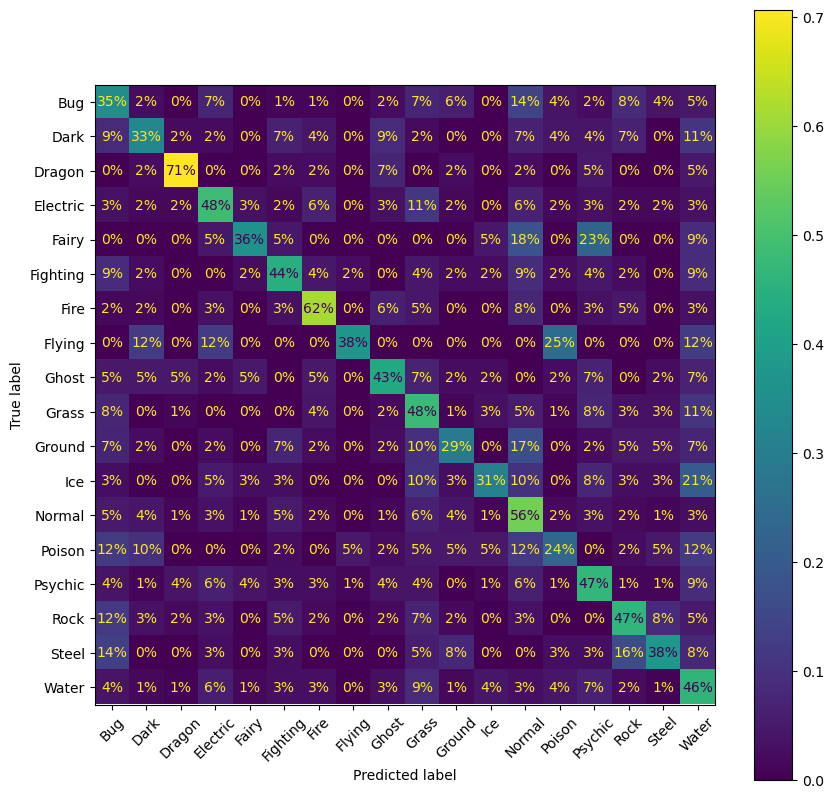

In [212]:
# Compute confusion matrix
# Set up label names
labels = y_label.unique().tolist()
labels.sort()

# Compute final prediction and final actual
pred_final = merge_list(pred_temp)
actual_final = merge_list(actual_temp)

# Create confusion matrix and normalize
cm = confusion_matrix(actual_final, pred_final, normalize='true')

# Set up plot
fix, ax = plt.subplots(figsize=(10,10))
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels)

# display
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
disp.plot(xticks_rotation=45, values_format='.0%',ax=ax)
plt.show()

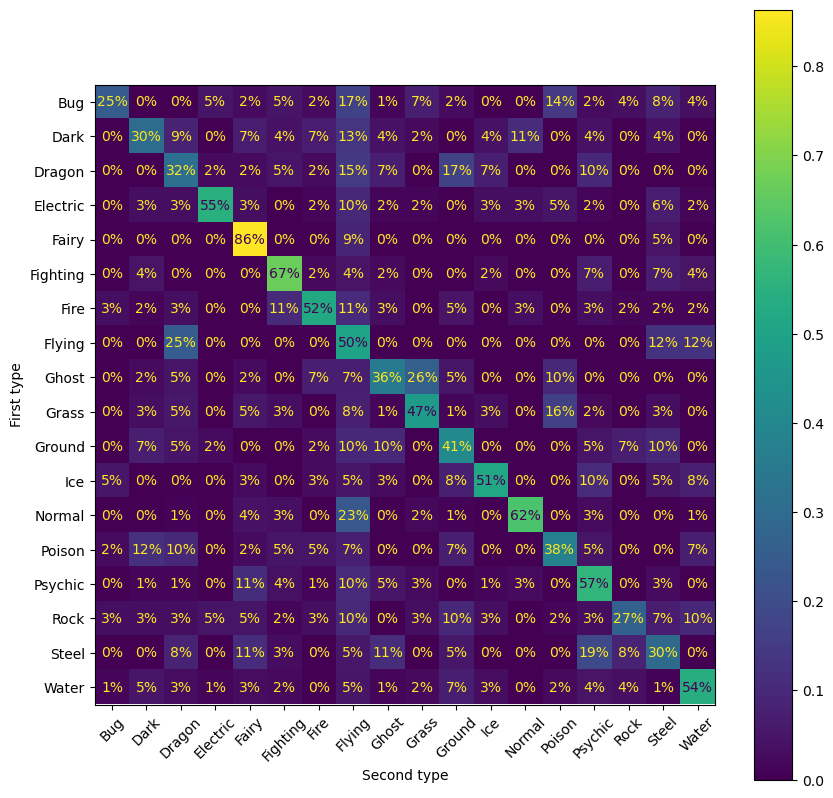

In [213]:
# Type1 label vs type2 label, y-axis being type1, x-axis being type2
for i in range(len(type_2_label)):
    if type_2_label[i] == "None":
        type_2_label[i] = type_1_label[i]
# Create confusion matrix
cm2 = confusion_matrix(type_1_label,type_2_label,normalize='true')

# Set up plot
fix,ax = plt.subplots(figsize=(10,10))
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels)

# Display
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2,display_labels=labels)
disp2.plot(xticks_rotation=45,values_format='.0%',ax=ax)
plt.xlabel('Second type')
plt.ylabel('First type')
plt.show()